# Run Galfit on 3DHST galaxies
- 11/09/2020: Updated to use galfit_helpers.py module

### Load modules

In [1]:
from __future__ import division
import sys
sys.path.insert(0,'/data/emiln/XLSSC122_GalPops/Analysis/Modules')
from GalfitPyWrap import galfitwrap as gf
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob
from scipy import ndimage
from astropy import units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.io import fits, ascii
from astropy.table import Table, hstack, join
import pickle
import fnmatch
import multiprocessing as mp
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import galfit_helpers as gfh

### Load 3DHST galaxy catalog

In [3]:
DHST_cat_root = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Products/catalogs/'
DHST_cat_filename = DHST_cat_root+'cosmos_3dhst.v4.1.cats/Catalog/cosmos_3dhst.v4.1.cat'
# full_df = gfh.load_3DHST_galaxy_catalog(DHST_cat_filename, mag='F140W',magthresh=None, overwrite=False, verbose=True,goodfit=False)
full_df = gfh.load_3DHST_galaxy_catalog(DHST_cat_filename, mag='F140W',magthresh=30, overwrite=False, verbose=True,goodfit=False)
# z2_filtered_df = gfh.load_3DHST_galaxy_catalog(DHST_cat_filename,  mag='F140W', magthresh=24, z=2.00, z_thresh=0.1, overwrite=False, verbose=True, goodfit=True) 
z2_filtered_df = gfh.load_3DHST_galaxy_catalog(DHST_cat_filename,  mag='F140W', magthresh=24, z=2.00, z_thresh=0.3, overwrite=False, verbose=True, goodfit=True) 

Checking if catalog exists at /data/emiln/XLSSC122_GalPops/Data/3DHST/Products/catalogs/magthresh30.csv
Catalog already exists, returning DataFrame
Checking if catalog exists at /data/emiln/XLSSC122_GalPops/Data/3DHST/Products/catalogs/magthresh24_z2.0_zthresh0.3.csv
Catalog does not exist
Creating catalog...
Filtering objects to F140W<24
Filtering objects to 1.7<z<2.3
Filtering to objects with good catalog fits
Saving catalog to /data/emiln/XLSSC122_GalPops/Data/3DHST/Products/catalogs/magthresh24_z2.0_zthresh0.3.csv
Returning DataFrame


In [4]:
print(len(z2_filtered_df))

433


### Set Galfit parameters

In [5]:
# fit_df = filtered_df[0:4]
fit_df = z2_filtered_df
df_name = '3DHST_z2_full'
psf_root = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Products/PSF/'
# psf_file = psf_root+'cosmos_3dhst.v4.0.F140W_psf.fits' # Filename causes galfit to seg fault
psf_file = psf_root+'F140W_PSF.fits'
PSFf = 1 
# convbox='64 64'
convbox='128 128'
image_width = 400 # 200 for mag<23 objects, 400 for z2 objects
timeout=5*60
verbose=True
width=10
HLRwidth=5 # Cutout width = 2*HLwidth
PA_INIT = 45
AR_INIT = 0.5
ZP = 26.465 # https://iopscience.iop.org/article/10.1088/0067-0049/214/2/24/pdf page 13
# ZP = 25
# page 20 --> All cataloged fluxes are normalized to AB zero point = 25
MAG_INIT = 21
fitMagnitude = True
neighbourMagThresh=3
DYNMAG = True
sky='Default'
sky_INIT=0.00001
sigma_file = '/sigma_rms_meanexp_cps.fits'
data_file = '/data_cps.fits'
constraint_file = 'galfit_constr.txt' # Matches van der wel 2012 constraints
# constr_file = 'none'
badmask='none'
save_name = None

In [6]:
params = {
    'survey':'3DHST',
    'fit_df':fit_df, # Dataframe with objects to be fit
    'full_df':full_df, # Unfiltered source catalog used for fitting neighbours
    'width':width, # Fitting region width in pixels
    'HLRwidth':HLRwidth, # Fitting region width in # of HLR
    'sigma_file':sigma_file, # Filename of sigma maps for sources
    'data_file':data_file, # Filename for data cutouts for each source
    'PSF_file':psf_file, # File_name of PSF to be used
    'usePSF':True, # Use PSF in fitting?
    'timeout':timeout, # Max runtime per object in seconds
    'PSFf':PSFf, # Fine sampling factor
    'verbose':verbose, # Verbose mode
    'PA_INIT':PA_INIT, # Initial position angle
    'AR_INIT':AR_INIT, # Initial axis ratio
    'MAG_INIT':MAG_INIT, # Initial magnitude
    'convbox':convbox, # Region to convolve PSF with in pixels (i.e. '100 100')
    'ZP':ZP, # Zeropoint 
    'constraint_file':constraint_file, # Galfit constraint filename
    'image_width':image_width, # Size of data+sigma images being used (200 for COSMOS cutouts)
    'useDYNMAG':DYNMAG, # Initialize magnitudes from catalog?
    'badmask':badmask, # filename for bad pixel mask
    'fitMagnitude':fitMagnitude, # Fit magnitudes?
    'sky':sky, # Sky fitting mode for galfit (i.e. 'default')
    'sky_INIT':sky_INIT, # Initial sky level
    'neighbourMagThresh':neighbourMagThresh, # Additional magnitude threshhold to fit neighbours (i.e. 3 -> only neighbours with mag < source_mag+3 are fit)
    'df_name': df_name, # Descriptive name of catalog being fit
    'save_name':save_name # Filename to save results to, overrides default
}

In [7]:
new_df, savename = gfh.run_galfit_parallel(params,**params) # Feeds in unwrapped params as well as a copy to be passed as kwargs to sub functions

th: 400
Cutoutwidth (pixels) for ID 26039 : 46
Cutoutwidth (arcsec) for ID 26039 : 2.76
Bounds: [377, 423, 377, 423]
0 NEIGHBOURS FOUND
Adding additional model components for neighbours...
Using PSF
Running galfit from CWD: /data/emiln/XLSSC122_GalPops/Data/Products/3DHST/galfit_results/26039
1_XC 400.7698 +/- 0.0354
1_YC 400.8021 +/- 0.0325
1_MAG 22.4266 +/- 0.0345
1_RE 2.5685 +/- 0.1202
1_N 3.4304 +/- 0.4426
1_AR 0.7714 +/- 0.0301
1_PA 80.2847 +/- 4.6280
2_XC [400.0000]
2_YC [400.0000]
2_SKY -1.404e-03 +/- 3.751e-04
2_DSDX [0.000e+00]
2_DSDY [0.000e+00]
**** 26039 ****
[{'1_RE': '2.5685 +/- 0.1202', '1_N': '3.4304 +/- 0.4426', '1_MAG': '22.4266 +/- 0.0345', '1_YC': '400.8021 +/- 0.0325', '1_XC': '400.7698 +/- 0.0354', '1_PA': '80.2847 +/- 4.6280', '1_AR': '0.7714 +/- 0.0301', 'COMP_1': 'sersic'}, {'2_YC': '[400.0000]', '2_SKY': '-1.404e-03 +/- 3.751e-04', '2_XC': '[400.0000]', '2_DSDX': '[0.000e+00]', '2_DSDY': '[0.000e+00]', 'COMP_2': 'sky'}]
['2.5685']
['0.1202']
['22.4266']
['0.03

### Validate results

In [8]:
new_df

,ID,ra,dec,re,re_err,ar,ar_err,n,n_err,mag,mag_err,sky,sky_err,chi2nu,ErrorValue
0,691,150.104736,2.187411,3.3884,0.2475,0.3654,0.0517,1.9423,0.5100,23.8350,0.0482,-0.002535,0.000334,0.176159,0
1,1194,150.097778,2.192021,3.1043,0.1847,0.6900,0.0524,1.6098,0.3540,23.6160,0.0463,-0.002936,0.000362,0.166024,0
2,2062,150.131638,2.200557,5.9251,0.3541,0.5559,0.0306,0.7501,0.1322,23.9613,0.0361,-0.004133,0.000199,0.164639,0
3,2140,150.147583,2.201060,6.8119,0.6494,0.5842,0.0402,1.0652,0.1661,23.6125,0.0718,-0.006408,0.000320,0.105534,0
4,2302,150.067230,2.204726,7.1399,0.2369,0.3767,0.0100,1.5731,0.0919,22.3135,0.0198,-0.005742,0.000219,0.161339,0
5,2331,150.138916,2.202856,4.3792,0.2601,0.3908,0.0324,1.5878,0.2620,23.6156,0.0427,-0.002238,0.000289,0.158887,0
6,2544,150.152527,2.205080,2.6871,0.1491,0.5353,0.0498,1.2344,0.3154,23.7778,0.0256,-0.004156,0.000515,0.170279,0
7,2633,150.123428,2.205652,6.3355,0.3940,0.3913,0.0248,0.9676,0.1550,23.7735,0.0417,-0.003143,0.000284,0.169895,0
8,2712,150.138916,2.206575,2.3464,0.1619,0.6385,0.0553,1.5430,0.3921,23.7896,0.0315,-0.004378,0.000384,0.164614,0
9,2716,150.177567,2.208040,12.6162,0.3625,0.2233,0.0054,1.5551,0.0600,21.9976,0.0176,-0.003181,0.000162,0.126695,0


    ID          ra       dec      re  re_err      ar  ar_err       n  n_err  \
0  691  150.104736  2.187411  3.3884  0.2475  0.3654  0.0517  1.9423   0.51   

      mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
0  23.835   0.0482 -0.002535  0.000334  0.176159           0  


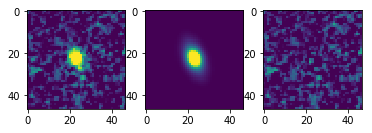

     ID          ra       dec      re  re_err    ar  ar_err       n  n_err  \
1  1194  150.097778  2.192021  3.1043  0.1847  0.69  0.0524  1.6098  0.354   

      mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
1  23.616   0.0463 -0.002936  0.000362  0.166024           0  


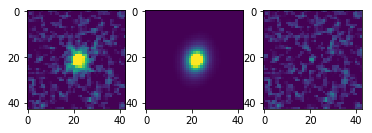

     ID          ra       dec      re  re_err      ar  ar_err       n   n_err  \
2  2062  150.131638  2.200557  5.9251  0.3541  0.5559  0.0306  0.7501  0.1322   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
2  23.9613   0.0361 -0.004133  0.000199  0.164639           0  


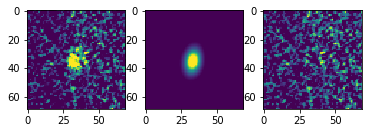

     ID          ra      dec      re  re_err      ar  ar_err       n   n_err  \
3  2140  150.147583  2.20106  6.8119  0.6494  0.5842  0.0402  1.0652  0.1661   

       mag  mag_err       sky  sky_err    chi2nu  ErrorValue  
3  23.6125   0.0718 -0.006408  0.00032  0.105534           0  


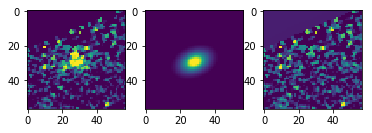

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
4  2302  150.06723  2.204726  7.1399  0.2369  0.3767    0.01  1.5731  0.0919   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
4  22.3135   0.0198 -0.005742  0.000219  0.161339           0  


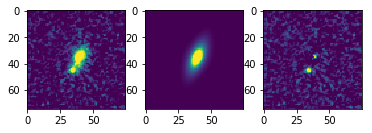

     ID          ra       dec      re  re_err      ar  ar_err       n  n_err  \
5  2331  150.138916  2.202856  4.3792  0.2601  0.3908  0.0324  1.5878  0.262   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
5  23.6156   0.0427 -0.002238  0.000289  0.158887           0  


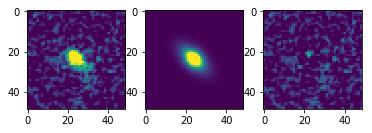

     ID          ra      dec      re  re_err      ar  ar_err       n   n_err  \
6  2544  150.152527  2.20508  2.6871  0.1491  0.5353  0.0498  1.2344  0.3154   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
6  23.7778   0.0256 -0.004156  0.000515  0.170279           0  


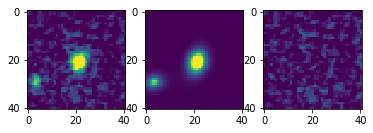

     ID          ra       dec      re  re_err      ar  ar_err       n  n_err  \
7  2633  150.123428  2.205652  6.3355   0.394  0.3913  0.0248  0.9676  0.155   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
7  23.7735   0.0417 -0.003143  0.000284  0.169895           0  


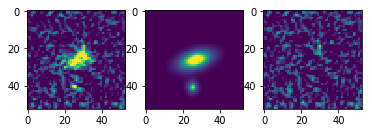

In [9]:
# Plot fits by ID
for ID in fit_df['ID'][0:8]:
    print fit_df[fit_df['ID']==ID]
    gfh.plot_by_ID(ID,save_name=savename,survey='3DHST')